# Gym solving - PPO
---
- PPO(Proximal Policy Optimization)

In [1]:
# 해당 셀은 필자의 Jupyter notebook 환경 문제로 인해 작성되었습니다
import os
try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym

import sys
sys.path.append('../material')
from utils import moving_average, discounted_reward

from IPython.display import clear_output
from IPython.display import Video

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
env = gym.make('CartPole-v0')
env._max_episode_steps=2000

/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


# PPO agent생성

In [6]:
class PPO_Actor(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(PPO_Actor,self).__init__()
        '''
        입력변수
            state_shape: state 차원 -> [위치, 속도, 각도, 각속도]
            output_dim: actor 차원 -> [왼쪽, 오른쪽]
                        critic 차원 -> 1
            device : cpu, cuda device정보 
        N.N 구조
            2 - hidden layers, 64 nodes
            Activation function -> Relu
        '''
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,64), 
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,n_actions)
        )
        
    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            policy : 정책([batch,n_actions]), torch.tensor
        '''
        policy = self.seq(state_t)
        return policy

    def sample_actions(self,state_t):
        '''
        입력인자
            state_t : 상태([1,state_shape]), torch.tensor
        출력인자
            action_t : 행동함수 using torch.multinomial
        '''
        policy = self.forward(state_t)
        policy = torch.squeeze(policy)
        softmax_policy = F.softmax(policy,dim=0)
        action = torch.multinomial(softmax_policy, num_samples=1).item()
        return action

class PPO_Critic(nn.Module):
    def __init__(self, state_shape):
        super(PPO_Critic,self).__init__()
        '''
        입력 정보 및 출력정보는 Actor와 상당 부분 공유
        출력 층만 Value를 계산하도록 변경
        '''
        self.state_shape = state_shape
        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,64), 
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    
    def forward(self, state_t):
        '''
        입력인자
            state_t : 상태([batch,state_shape]), torch.tensor
        출력인자
            value : 가치함수([batch]), torch.tensor
        '''
        value = self.seq(state_t).squeeze(dim=-1)
        return value
    

In [7]:
gamma=0.99
epsilon = 1e-03

state = env.reset()
num_state = state.shape[0]
num_action = env.action_space.n
learning_rate = 5e-04
max_episode = 1000
update_per_episode=10

# Clipped Surrogate Objective
---
Objective function

$$

J(\theta) = \mathbb{E}_t[min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t)]

$$

where,
$r_t(\theta) = \frac{\pi{(a_t \vert s_t)}}{\pi_{old}(a_t \vert s_t)}$

In [13]:
actor = PPO_Actor(num_state,num_action).to(device)
critic = PPO_Critic(num_state).to(device)
actor_optimizer = optim.Adam(actor.parameters(),lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(),lr=learning_rate)

In [14]:
var = torch.full(size=(2,),fill_value=0.5)
mat = torch.diag(var)
print(f'var: {var}')
print(f'mat: {mat}')

var: tensor([0.5000, 0.5000])
mat: tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])


In [15]:
def PPO_rollout(env,actor):
    # rollout - env reset된 상태
    states,  rewards, policies = [], [], []
    state = env.reset()
    total_reward = 0
    for t in range(env._max_episode_steps):
        torch_state = torch.Tensor(state).to(device)
        torch_state = torch.unsqueeze(torch_state,0)
        policy = actor(torch_state).detach().cpu().numpy().ravel()
        action = actor.sample_actions(torch_state)
        next_state,reward,done,_ = env.step(action)

        states.append(state)
        rewards.append(reward)
        policies.append(policy)
        
        total_reward += reward
        if done:
            break
        state = next_state

    learning_history = (states,rewards,policies)
    return learning_history, total_reward

In [16]:
def PPO_training(history,actor,critic,updates=10, clips=0.2):
    states, rewards, policies = history
    torch_states = torch.Tensor(states).to(device)
    torch_Advantage = torch.Tensor(discounted_reward(rewards,gamma)).to(device)

    old_policies = torch.Tensor(policies).to(device)
    old_logpolicy = F.log_softmax(old_policies,dim=-1)
    old_logpolicy = torch.max(old_logpolicy,dim=-1).values

    value = critic(torch_states)
    Advantage = torch_Advantage - value.detach()
    # Advantage - 정규화 학습의 안정성
    Advantage = (Advantage - Advantage.mean())/(Advantage + 1e-10)

    for i in range(updates):
        value = critic(torch_states)
        new_policies = actor(torch_states)
        new_logpolicy = F.log_softmax(new_policies,dim=-1)
        new_logpolicy = torch.max(new_logpolicy,dim=-1).values

        rt = torch.exp(new_logpolicy - old_logpolicy)
    
        candid_1 = rt*Advantage
        candid_2 = torch.clip(rt, 1-clips, 1+clips)*Advantage
        
        # 목적함수 설정
        actor_loss = -torch.mean(torch.min(candid_1, candid_2))
        critic_loss = torch.mean((Advantage - value)**2)

        # 최적화 시행
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        #actor_loss.backward(retain_graph=True)
        actor_loss.backward()
        critic_loss.backward()
        actor_optimizer.step()
        critic_optimizer.step()
    return actor, critic

In [18]:
actor = PPO_Actor(num_state,num_action).to(device)
critic = PPO_Critic(num_state).to(device)
actor_optimizer = optim.Adam(actor.parameters(),lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(),lr=learning_rate)

870번째 에피소드 결과
최근 10 에피소드 보상평균 = 10.1


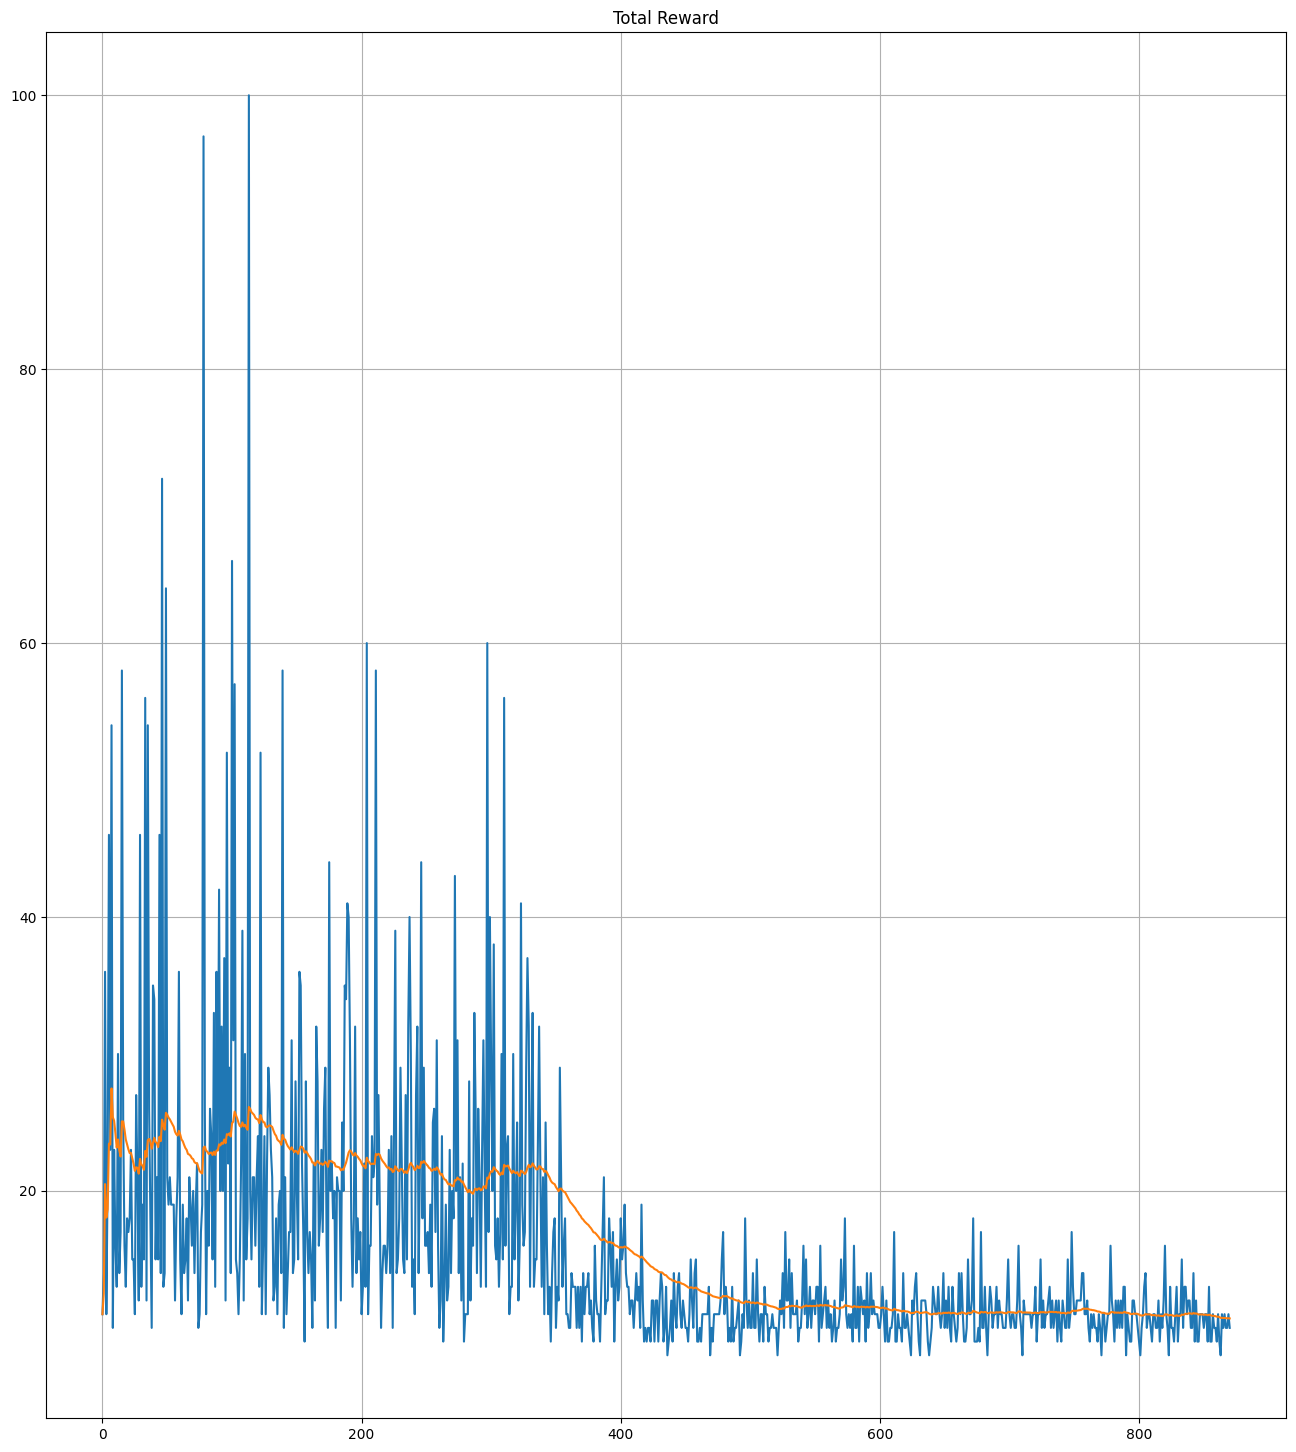

KeyboardInterrupt: 

In [19]:
reward_record = []
for ep in range(max_episode):
    history, total_reward = PPO_rollout(env,actor)
    actor,critic = PPO_training(history, actor, critic)
    reward_record.append(total_reward)

    if ep % 10 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'최근 10 에피소드 보상평균 = {np.mean(reward_record[-10:])}')

        plt.figure(figsize=[16, 18])
        
        plt.subplot(1,1,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()
        plt.show()

In [ ]:
from torch.distributions import MultivariateNormal
